# fastai, chapter 2

This is a blog post to synthesize some knowledge from Chapter 2 of the [fastai course](https://course.fast.ai/).

In this chapter, we continued discussing the fundamentals of machine learning development. We also grabbed photos of bears from the internet and used a pretrained image model (ResNet18) to predict what kind of bear an image contains. We also discussed how to save the model to disk and use it for inference in the future. Last, we made a graphical app which called our model under the hood.

In this notebook, I'll reproduce the steps myself for fine-tuning a pretrained image model. The model will decide if an image contains Crocs, Samba, or Timberland shoes.

I won't reproduce the steps of making or deploying a graphical app yet. I understand this is important, but I am focusing on experience with ML models for now.

In [1]:
# imports
import os
from pathlib import Path

# fastai imports
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

In [2]:
# Model categories
shoe_types = "crocs", "samba", "timberland"

In [3]:
# Get images

# This is necessary:
#   `export AZURE_SEARCH_KEY=[the bing search api key]`

key = os.environ["AZURE_SEARCH_KEY"]
path = Path("shoes")
path.mkdir(exist_ok=True)

for shoe_type in shoe_types:
    print(f"On {shoe_type} ...")
    shoe_path = path/shoe_type
    shoe_path.mkdir(exist_ok=True)
    results = search_images_bing(key, f"{shoe_type} shoes")
    download_images(shoe_path, urls=results.attrgot("contentUrl"))

On crocs ...
On samba ...
On timberland ...


In [4]:
# For reference: what does a result look like?
results[0]

{'webSearchUrl': 'https://www.bing.com/images/search?view=detailv2&FORM=OIIRPO&q=timberland+shoes&id=CAED57C8E6D4DF7F78A411E43DD080B41725A619&simid=608030351921721354',
 'name': 'Timberland® Premium 6" Waterproof Boot - Timberland - Hong Kong',
 'thumbnailUrl': 'https://tse1.mm.bing.net/th?id=OIP.4mMtM6Sytim5j0vT8tsWowHaHa&pid=Api',
 'datePublished': '2020-02-03T06:03:00.0000000Z',
 'isFamilyFriendly': True,
 'contentUrl': 'https://www.timberland.com.hk/wp-content/uploads/2020/01/A2D6U231-HERO.jpg',
 'hostPageUrl': 'https://www.timberland.com.hk/en/products/a2d6u231-timberland-premium-6-waterproof-boot/',
 'contentSize': '856895 B',
 'encodingFormat': 'jpeg',
 'hostPageDisplayUrl': 'https://www.timberland.com.hk/en/products/a2d6u231-timberland-premium-6-waterproof-boot',
 'width': 3000,
 'height': 3000,
 'hostPageDiscoveredDate': '2020-02-03T06:03:00.0000000Z',
 'isTransparent': False,
 'thumbnail': {'width': 474, 'height': 474},
 'imageInsightsToken': 'ccid_4mMtM6Sy*cp_2A8666E3529BA65

In [5]:
# For reference: how much stuff did we download?
! du -hs shoes
! du -hs shoes/*
! for shoe in shoes/*; do echo "$shoe has $(ls -1 $shoe | wc -l | tr -d ' ') images"; done

103M	shoes
 35M	shoes/crocs
 25M	shoes/samba
 43M	shoes/timberland
shoes/crocs has 141 images
shoes/samba has 138 images
shoes/timberland has 139 images


In [6]:
# Lets remove images which cant be opened (clean some data)
failed = verify_images(get_image_files(path))
print(f"Number of bad images: {len(failed)}")
failed.map(Path.unlink)

Number of bad images: 52


(#52) [None,None,None,None,None,None,None,None,None,None...]

In [11]:
# Lets create data objects for our image data
# This is fastai voodoo which I understand conceptually but not yet line-by-line

# This might be necessary if running on mac:
#   `export PYTORCH_ENABLE_MPS_FALLBACK=1`

shoes = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms(),
)
dataloaders = shoes.dataloaders(path)

In [8]:
# Lets fine-tune a resnet18 model!
learn = vision_learner(dataloaders, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.664773,0.945336,0.291667,00:14


/opt/homebrew/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.581421,0.346846,0.125000,00:13
1,0.446465,0.147050,0.041667,00:14
2,0.361275,0.095613,0.041667,00:13
3,0.282883,0.069520,0.027778,00:14


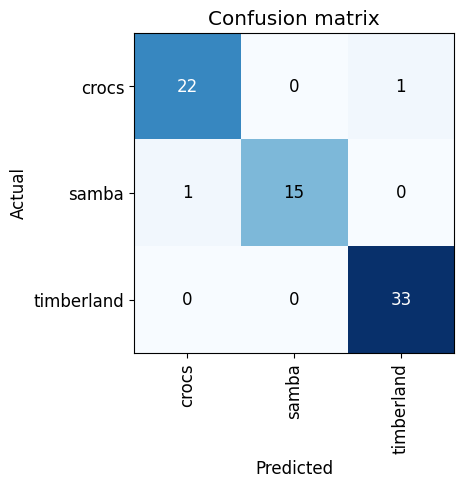

In [9]:
# Thats pretty good for a handful of images
# Lets make a confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

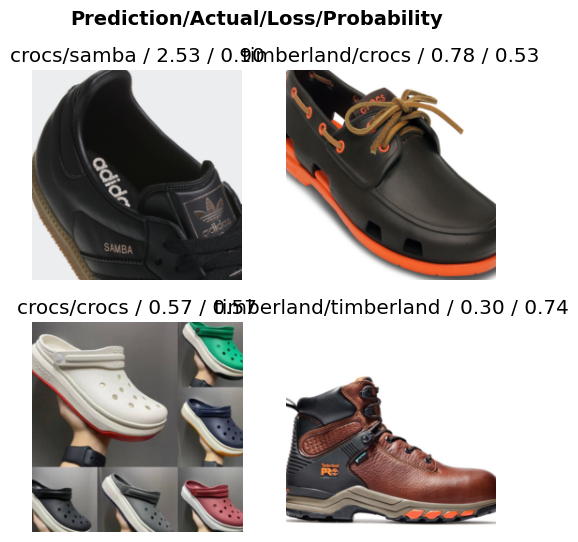

In [10]:
# Lets look at the images where the model struggled the most.
# They might be garbage images, since we blindly accepted what the internet gave us.
interp.plot_top_losses(4, nrows=2)

That was fun. And such little code to write. Thanks fastai.

The mis-identified images are interesting. Those black Crocs are especially heinous. But okay! One step at a time.

# Questionnaire

Q: Provide an example of where the bear classification model might work poorly in production, due to structural or style differences in the training data.

A: If the training data is images taken from the internet, then the training data is likely to include lots of images of bears facing the camera. In the wild, however, a bear classification model would be expected to recognize bears from all angles.

Q: Where do text models currently have a major deficiency?

A: Woof, that's a tricky question in 2024. Text models are really good these days. Some areas for improvement could be biases in the training dataset which reflect the bias of the internet, logical reasoning, and being confidently incorrect.

Q: What are possible negative societal implications of text generation models?

A: They can and will reflect the biases of text on the internet. The chapter mentions an example of a predictive policing model, where more police are dispatched to areas where the model expects more arrests. But this is an arrest prediction model, not a crime prediction model. So if people in an area are disproportionately arrested relative to another area, this model would reinforce that disparity.

Q: In situations where a model might make mistakes, and those mistakes could be harmful, what is a good alternative to automating a process?

A: Piece-wise and gradual rollout! For example, at first, allow the model to make predictions, and have humans review every prediction. This will probably catch big problems. Then gradually expand the impact of the model. For example, allow the model to make predictions and take action in a small, manageable subset of the big picture. And so on. Ideally, each expansion is manageable and reviewable.

Q: What kind of tabular data is deep learning particularly good at?

A: I think deep learning is particularly good at tabular data with many inputs. I dont really know yet though! I havent tried it.

Q: What's a key downside of directly using a deep learning model for recommendation systems?

A: The models tend to tell us what a user would like, but not necessarily what a user would buy.

Q: What are the steps of the Drivetrain Approach?

A: Define objective; input levers; data; models.

Q: How do the steps of the Drivetrain Approach map to a recommendation system?

A: Objective: increase a users probability of buying something. Input levers: ranking of recommendations. Data: ideally, we would run experiments with and without recommendations, and under a variety of other circumstances. Models: predicting the probability of a purchase under different recommendation circumstances.

Q: Create an image recognition model using data you curate, and deploy it on the web.

A: Not right now.

Q: What is DataLoaders?

A: Dataloaders is a fastai layer on top of the pytorch DataLoader class, which is meant to be an efficient interface to the training, validation, and testing data.

Q: What four things do we need to tell fastai to create DataLoaders?

A: Blocks to define the inputs and outputs; a function to get the inputs; a function to get the input labels; and the parameters for splitting the data.

Q: What does the splitter parameter to DataBlock do?

A: This defines the split of data into training, validation, and testing datasets.

Q: How do we ensure a random split always gives the same validation set?

A: We use a fixed random seed.

Q: What letters are often used to signify the independent and dependent variables?

A: x (independent) and y (dependent).

Q: What's the difference between the crop, pad, and squish resize approaches? When might you choose one over the others?

A: Crop cuts the image to fit dimensions; pad adds empty pixels to fit dimensions; and squish interpolates pixel values to fit dimensions. Crop and pad are computationally inexpensive which is nice. Pad is a bit wasteful. Squish messes with the aspect ratio, which is unfortunate.

Q: What is data augmentation? Why is it needed?

A: Data augmentation is the practice of changing the training data to artificially improve the amount of information in the training dataset. Cropping and warping are examples. It's not needed per se, but its very handy for improving the effective statistics of the training.

Q: What is the difference between item_tfms and batch_tfms?

A: item_tfms are transforms applied to individual inputs, and batch_tfms are applied to batches.

Q: What is a confusion matrix?

A: A confusion matrix is a plot which shows for each item with truth label X, how often does the model assign label Y. A diagonal-only confusion matrix is a perfectly performing confusion matrix.

Q: What does export save?

A: `export` saves the model architecture and weights into a pickle file.

Q: What is it called when we use a model for getting predictions, instead of training?

A: Inference!

Q: What are IPython widgets?

A: IPython widgets are graphical tools for interacting with the user. Theyre a bridge between python and javascript.

Q: When might you want to use CPU for deployment? When might GPU be better?

A: CPU are typically cheaper, and fine for processing individual inferences. GPU are typically much faster, especially for large models, or for processing many inferences in parallel.

Q: What are the downsides of deploying your app to a server, instead of to a client (or edge) device such as a phone or PC?

A: Some downsides of deploying an app to a server include significant data transfer and latency if the inputs/outputs are large, and safety risks of transfering data to/from the server.

Q: What are three examples of problems that could occur when rolling out a bear warning system in practice?

A: The model may be trained on bears facing the camera, as opposed to bears from all angles; the model may be trained on photos from images instead of photos from videos; the model may be trained on daytime images, as opposed to images from all times.

Q: What is "out-of-domain data"?

A: Out-of-domain data refers to doing inference on data in which the model wasnt trained for.

Q: What is "domain shift"?

A: Domain shift refers to data relevant to the model shifting (changing) in time.

Q: What are the three steps in the deployment process?

A: Manual process, limited scope deployment, and gradual expansion!
